In [1]:
input_image_path = 'test' # 'real_integrals//focal_stack'  # 'real_integrals' # 'test'
datatype = 'tiff'  # 'tiff' # "png"   # has to be set to tiff for the testfolder
get_info_every = 5
make_plots = True
generate_outputs = True
output_folder = 'final_real_world_predictions'

In [2]:
from pathlib import Path
from utils import calculate_psnr_tensor, calculate_ssim_tensor
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import cv2
import json
from glob import glob
from tqdm import tqdm

# import numpy as np
import torch.nn.functional as F

from torchvision.transforms import Resize

from swin2sr import Swin2SR as Swin
from dataset import PositionDataset

def load_model(path: str):
    model = Swin(img_size=512,
                 in_chans=1,
                 window_size=8,
                 depths=[2, 2, 2, 2],
                 num_heads=[4, 4, 4, 4],
                 embed_dim=32,
                 mlp_ratio=4,
                 img_range=1.,
                 ape=True,
                 use_checkpoint=True).cuda()
    
    existing_model_state = Path(path)
    if not existing_model_state.exists():
        print(f"Model state not found at {existing_model_state.absolute()}")
        exit(1)
    
    print(f"Using the existing model state from {existing_model_state.absolute()}")
    model.load_state_dict(torch.load(existing_model_state))

    model.eval()

    return model

def tens2img(tensor: torch.Tensor):
    '''Move the axes of a 3D Tensor such that it can be plotted as an image'''
    return np.moveaxis(tensor.detach().cpu().numpy(), 0,-1)

def load_tiff(path: str, focal_idx: list):
    '''Load the tiff image from the given path, select the goven focal heights (using the index).
    Return a Tensor of shape (num_focal_heights, H, W) with pixel values in the range [0-155]'''
    ok, focal_stack = cv2.imreadmulti(path)
    if not ok:
        raise IOError(f'Failed to load index: {path}')
        
    focal_stack = np.stack(focal_stack)   # shape (num_focal_lengths, H, W)
    focal_stack = focal_stack[focal_idx]
    focal_stack = torch.from_numpy(focal_stack)
    return focal_stack

def load_image(path: str, focal_idx: list):
    _, ext = os.path.splitext(path)

    if ext.lower() in ['.tiff', '.tif']:
        ok, focal_stack = cv2.imreadmulti(path, flags=cv2.IMREAD_ANYDEPTH)
        if not ok:
            raise IOError(f'Failed to load TIFF: {path}')
        focal_stack = np.stack(focal_stack)
    elif ext.lower() in ['.png', '.jpg', '.jpeg']:
        img = cv2.imread(path, cv2.IMREAD_ANYDEPTH)
        if img is None:
            raise IOError(f'Failed to load image: {path}')
        if len(img.shape) == 2:
            img = np.expand_dims(img, axis=-1)
        focal_stack = np.array([img])
    else:
        raise ValueError(f'Unsupported file format: {ext}')

    # Select specified focal indices
    focal_stack = focal_stack[focal_idx]

    # Convert to PyTorch tensor and scale
    focal_stack = torch.from_numpy(focal_stack).float()
    
    if focal_stack.dim() == 3:  # If there are only 3 dimensions, add a channel dimension
        focal_stack = focal_stack.unsqueeze(1)

    # Ensure consistent dimension order for PyTorch (B, C, H, W)
    focal_stack = focal_stack.permute(0, 3, 1, 2)  # Change dimension order
    
    if ext.lower() in ['.png', '.jpg', '.jpeg']:
        focal_stack = focal_stack[0]
    
    if focal_stack.shape != [1, 512, 512]:
        focal_stack = focal_stack.unsqueeze(1)
        focal_stack = F.interpolate(focal_stack, size=(512, 512), mode='bilinear')
        focal_stack = focal_stack.squeeze(1)
    
    return focal_stack

def preprocess(stack: torch.Tensor):
    '''Resize and normalize the images in the stack'''
    return Resize(512)(stack.contiguous().div(256))

@torch.no_grad()
@torch.autocast(device_type='cuda', dtype=torch.float16)
def self_ensemble(model: Swin, stack: torch.Tensor, passes:int = 2):
    '''Calculate the model output for the given input stack.
    The stack is assumed to be of shape (num_focal_height, H, W) with pixel values in the range [0,1].
    The stack is assumed to be ordered by ascending focal height, i.e. stack[0] is the closest to 0m (the floor)
    The model is assumed to only work on single channel images, so the results for different focal heights are calculated separately and then aggregated later'''

    get_rots = lambda x: [torch.rot90(x, i, (-2, -1)) for i in range(4)]
    undo_rots = lambda x: [torch.rot90(j, -i, (-2, -1)) for i, j in enumerate(x)]
    ### maybe also include flipped versions

    single_pass_denoised = None
    no_ensemble_denoised = None
    denoised = stack
    
    # feed the output through the model several times
    for _ in range(passes):
        fixed_preds = []
        for integral in denoised:
            integral = integral[None,:]  # see each integral as an individual grayscale image

            versions = torch.stack(get_rots(integral)).cuda()

            preds = model(versions)

            if no_ensemble_denoised is None:  # assume the first integral in the stack as the training height
                no_ensemble_denoised = preds[0].clone()  # store it's unmodified prediction for comparison

            fixed_preds += undo_rots(preds)

        denoised = torch.stack(fixed_preds).median(0).values

        if single_pass_denoised is None:
            single_pass_denoised = denoised.clone()

    # safeguard against making results worse
    if single_pass_denoised.std() < denoised.std():
        denoised = single_pass_denoised
    return no_ensemble_denoised, single_pass_denoised, denoised

def postprocess(stack: torch.Tensor):
    '''Convert the model output to the range [0, 255]'''
    return stack.mul(256).clip(0, 255).int()

def calculate_metrics(denoised, ground_truth):
    dn = denoised[None,:].float()
    gt = ground_truth[None,:].float()
    loss = nn.functional.l1_loss(dn, gt).item()
    psnr = calculate_psnr_tensor(gt, dn, 255.)
    ssim = calculate_ssim_tensor(gt, dn, 255.)
    return [loss, psnr, ssim]

def main():
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    if not os.path.exists(os.path.join(output_folder, input_image_path)):
        os.makedirs(os.path.join(output_folder, input_image_path))
    
    model = load_model('tmp/model_3199.pth')
    denoising_passes = 2

    focal_idx = [0]
    # input_image_path = 'test'    #0_130_2_-5_integral.tiff'

    # added different support of datatypes
    # every format supported by cv2.imreadmulti(path) is allowed: e.g. png, jpg
    # important: write datatype here without a "." in the beginning!

    # if a path to a directory was given, load all tiff files from there. Useful for calculating the loss over some dataset
    if os.path.isdir(input_image_path):
        print('Detected folder as input path, loading all files')
        image_files = glob(os.path.join(input_image_path, f"*.{datatype}"))
        
    # if the path is a file, treat it as if it's a dataset with only one sample. Makes further code more concise
    else:
        image_files = [input_image_path]

    ## make predictions
    multipass = denoising_passes > 1
    metrics, ensemble_metrics, multipass_metrics = [], [], []
    
    # Initialize gt before the loop
    # gt = False
    
    # Loop over all image files. Load each tiff file as a (num_focal_heights, H, W) Tensor, preprocess it and calculate the prediction
    for idx, f in enumerate(tqdm(image_files, desc='Calculating output(s)')):
        # stack = load_tiff(f, focal_idx)
        
        stack = load_tiff(f, focal_idx) if f.split('.')[-1]=='tiff' else load_image(f, focal_idx)
        stack = preprocess(stack)

        no_ensemble_denoised, single_pass_denoised, denoised = map(postprocess, self_ensemble(model, stack, denoising_passes))

        # If a ground truth image is present, calculate key metrics. Useful for getting an overview of the model on some dataset
        gt_path = f.removesuffix(f"integral.{datatype}") + 'gt.png'
        gt = os.path.exists(gt_path)
        
        if gt:
            ground_truth = torch.from_numpy(np.moveaxis(cv2.imread(gt_path)[...,[0]], -1, 0)).int().cuda()
            metrics.append(calculate_metrics(no_ensemble_denoised, ground_truth))
            ensemble_metrics.append(calculate_metrics(single_pass_denoised, ground_truth))
            multipass_metrics.append(calculate_metrics(denoised, ground_truth))
        
        if idx%get_info_every == 0:

            # if ground truths were available, print the results
            if gt:
                loss, psnr, ssim = np.mean(metrics, 0)
                ensemble_loss, ensemble_psnr, ensemble_ssim = np.mean(ensemble_metrics, 0)
                multipass_loss, multipass_psnr, multipass_ssim = np.mean(multipass_metrics, 0)
                
                print('\n                   L1 Loss / PSNR / SSIM:')
                print(f'Simple denoised:   {loss:.3f} / {psnr:.3f} / {ssim:.3f}')
                print(f'+ Ensemble:        {ensemble_loss:.3f} / {ensemble_psnr:.3f} / {ensemble_ssim:.3f}')
                if multipass:
                    print(f'+ Multi-Pass [{denoising_passes}]:  {multipass_loss:.3f} / {multipass_psnr:.3f} / {multipass_ssim:.3f}')
        
        
        # plot the last input-denoised pair
        fig, axes = plt.subplots(1, 3 + gt + multipass, figsize=(18,8), sharey=True, sharex=True)
        
        axes[0].imshow(tens2img(stack[[0]]), cmap='gray', vmin=0, vmax=1)
        axes[1].imshow(tens2img(no_ensemble_denoised), cmap='gray', vmin=0, vmax=255)
        axes[2].imshow(tens2img(single_pass_denoised), cmap='gray', vmin=0, vmax=255)

        axes[0].set_title('Input')
        axes[1].set_title('Denoised')
        axes[2].set_title('+ Self Ensemble')

        if multipass:
            axes[3].imshow(tens2img(denoised), cmap='gray', vmin=0, vmax=255)
            axes[3].set_title(f'+ Multi-Pass [{denoising_passes}]')

        if gt:
            axes[-1].imshow(tens2img(ground_truth), cmap='gray', vmin=0, vmax=255)
            axes[-1].set_title('Ground Truth')
                
        if generate_outputs:
            a5 = axes[3].imshow(tens2img(denoised), cmap='gray', vmin=0, vmax=255)
            
            image_data = denoised.squeeze().cpu().numpy()  # Adjust as necessary based on tensor dimensions

            # Construct the new file path
            path_components = f.split(os.path.sep)
            path_components[0] = os.path.join(output_folder, os.path.basename(input_image_path))  # Use 'basename' for safety

            # Extract the filename without the extension and add '.png'
            filename_without_extension = '.'.join(path_components[-1].split('.')[:-1])
            path_components[-1] = filename_without_extension + '.png'  # Change file extension to '.png'
            new_path = os.path.join(*path_components)

            # print(new_path)
            
            # Ensure the directory exists before saving the image
            save_dir = os.path.dirname(new_path)
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)

            # Save the image data to the new path
            plt.imsave(new_path, image_data, cmap='gray', vmin=0, vmax=255)
        
        if make_plots and idx%get_info_every == 0:
            plt.show()
        
        plt.close()

    # if ground truths were available, print the results
    if gt:
        loss, psnr, ssim = np.mean(metrics, 0)
        ensemble_loss, ensemble_psnr, ensemble_ssim = np.mean(ensemble_metrics, 0)
        multipass_loss, multipass_psnr, multipass_ssim = np.mean(multipass_metrics, 0)
        
        print('\n                   L1 Loss / PSNR / SSIM:')
        print(f'Simple denoised:   {loss:.3f} / {psnr:.3f} / {ssim:.3f}')
        print(f'+ Ensemble:        {ensemble_loss:.3f} / {ensemble_psnr:.3f} / {ensemble_ssim:.3f}')
        if multipass:
            print(f'+ Multi-Pass [{denoising_passes}]:  {multipass_loss:.3f} / {multipass_psnr:.3f} / {multipass_ssim:.3f}')


    # plot the last input-denoised pair
    fig, axes = plt.subplots(1, 3 + gt + multipass, figsize=(18,8), sharey=True, sharex=True)

    axes[0].imshow(tens2img(stack[[0]]), cmap='gray', vmin=0, vmax=1)
    axes[1].imshow(tens2img(no_ensemble_denoised), cmap='gray', vmin=0, vmax=255)
    axes[2].imshow(tens2img(single_pass_denoised), cmap='gray', vmin=0, vmax=255)

    axes[0].set_title('Input')
    axes[1].set_title('Denoised')
    axes[2].set_title('+ Self Ensemble')

    if multipass:
        axes[3].imshow(tens2img(denoised), cmap='gray', vmin=0, vmax=255)
        axes[3].set_title(f'+ Multi-Pass [{denoising_passes}]')

    if gt:
        axes[-1].imshow(tens2img(ground_truth), cmap='gray', vmin=0, vmax=255)
        axes[-1].set_title('Ground Truth')

    plt.show()

Using the existing model state from C:\Users\kroep\Desktop\AI\computer_vision\AOS_Project-main-2024-01-17\AOS_Project-main\code\tmp\model_3199.pth
Detected folder as input path, loading all files


Calculating output(s):   0%|                                                                  | 0/1064 [00:00<?, ?it/s]


                   L1 Loss / PSNR / SSIM:
Simple denoised:   10.405 / 21.084 / 0.852
+ Ensemble:        9.272 / 22.211 / 0.868
+ Multi-Pass [2]:  5.424 / 26.519 / 0.925
final_real_world_predictions\test\0_10010_N_N_integral.png


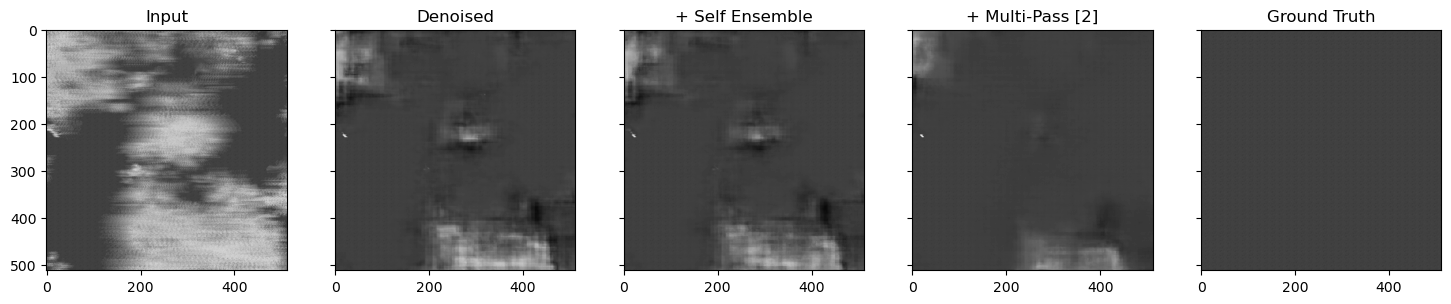

Calculating output(s):   0%|                                                        | 2/1064 [00:53<7:50:52, 26.60s/it]

final_real_world_predictions\test\0_10019_-8_7_integral.png


Calculating output(s):   0%|                                                        | 2/1064 [00:57<8:25:05, 28.54s/it]


KeyboardInterrupt: 

In [3]:
main()